# Fake News Detection Challenge KDD 2020

https://www.kaggle.com/competitions/fakenewskdd2020

- text: text of the article

- Label: a label that marks the article as potentially unreliable
    - 1: fake
    - 0: real

In [1]:
# import package
import pandas as pd

# Dataset
Read the KDD_raw.csv and delete the rows with missing values.

In [2]:
# load data
df = pd.read_csv('KDD_raw.csv', sep='\t', encoding='utf-8')
print(f"Data shape: {df.shape}")
print(df.head())

Data shape: (4987, 2)
                                                text label
0  Get the latest from TODAY Sign up for our news...     1
1  2d  Conan On The Funeral Trump Will Be Invited...     1
2  It’s safe to say that Instagram Stories has fa...     0
3  Much like a certain Amazon goddess with a lass...     0
4  At a time when the perfect outfit is just one ...     0


# Data Cleaning

In [3]:
# check NaN values
print(f"Null values in data:")
print(df.isnull().sum())

Null values in data:
text     0
label    0
dtype: int64


In [4]:
# print unique labels
print(f"Unique labels in data:")
print(df['label'].unique())

Unique labels in data:
['1' '0' 'label']


## Delete the data whose label is not ['0', '1']

since our label can only contains:
- 1: fake
- 0: true

In [5]:
# find the row that label == 'label'
print(f"Rows with label 'label': ")
print(df[df['label'] == 'label'])

Rows with label 'label': 
         text  label
1615  content  label


In [6]:
# remove the row that label == 'label'
df = df[df['label'] != 'label']

In [7]:
# save labels as int type
df['label'] = df['label'].astype(int)

In [9]:
# reset the index
df.reset_index(drop=True, inplace=True)

# info
print(df.info())
print(df.head())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4986 non-null   object
 1   label   4986 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.0+ KB
None
                                                text  label
0  Get the latest from TODAY Sign up for our news...      1
1  2d  Conan On The Funeral Trump Will Be Invited...      1
2  It’s safe to say that Instagram Stories has fa...      0
3  Much like a certain Amazon goddess with a lass...      0
4  At a time when the perfect outfit is just one ...      0
(4986, 2)


# Train Val Test Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Define the split sizes
train_size = 0.7
val_size = 0.20
test_size = 0.10

# First, split into train and temp (val + test)
train_df, temp_df = train_test_split(df, test_size=(val_size + test_size))

# Now split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=(test_size / (val_size + test_size)))

In [13]:
print(f'Raw data set size: {len(df)}')
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Raw data set size: 4986
Training set size: 3490
Validation set size: 997
Test set size: 499


## Output

In [13]:
train_df.to_csv('train.csv', sep='\t', index=False, encoding='utf-8')
print(f"Training data saved as train.csv")
val_df.to_csv('val.csv', sep='\t', index=False, encoding='utf-8')
print(f"Validation data saved as val.csv")
test_df.to_csv('test.csv', sep='\t', index=False, encoding='utf-8')
print(f"Test data saved as test.csv")

Training data saved as train.csv
Validation data saved as val.csv
Test data saved as test.csv


# EDA

In [14]:
import matplotlib.pyplot as plt
import numpy as np

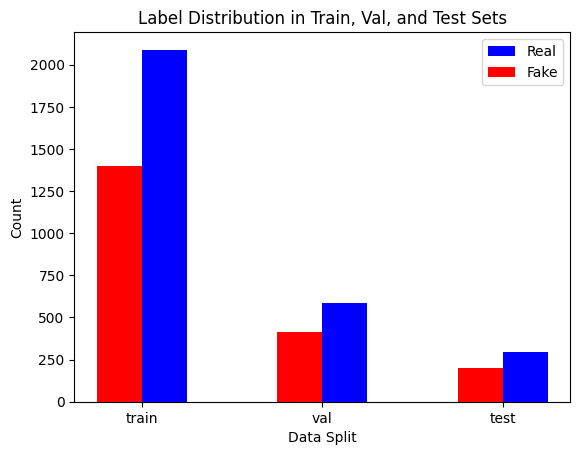

In [15]:
# Count the occurrences of 'fake' and 'real' in each split
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Combine the counts into a single DataFrame for plotting
counts_df = pd.DataFrame({
    'train': train_counts,
    'val': val_counts,
    'test': test_counts
}).T

# Plotting
fig, ax = plt.subplots()

# Define the bar width
bar_width = 0.25

# Set position of bar on X axis
r1 = range(len(counts_df))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r2, counts_df[0], color='b', width=bar_width, label='Real')
ax.bar(r1, counts_df[1], color='r', width=bar_width, label='Fake')

# Add labels
ax.set_xlabel('Data Split')
ax.set_ylabel('Count')
ax.set_title('Label Distribution in Train, Val, and Test Sets')
ax.set_xticks([r + bar_width/2 for r in range(len(counts_df))])
ax.set_xticklabels(counts_df.index)

# Add legend
ax.legend()

# Show the plot
plt.show()

# Create HugginFace Dataset

In [17]:
from datasets import Dataset, DatasetDict

/home/littlefish/miniconda3/envs/fakenews/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Step 1: Create datasets from pandas
train_dataset = Dataset.from_pandas(train_df).remove_columns(['__index_level_0__'])
val_dataset = Dataset.from_pandas(val_df).remove_columns(['__index_level_0__'])
test_dataset = Dataset.from_pandas(test_df).remove_columns(['__index_level_0__'])

# Step 2: Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Add Bert Embedding

In [38]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(f"google-bert/bert-base-uncased", clean_up_tokenization_spaces=True)
model = AutoModel.from_pretrained(f"google-bert/bert-base-uncased").to(device)

In [40]:
def generate_bert_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    
    # Get the BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    
    return embeddings

In [41]:
def add_embeddings(batch):
    batch['bert_embeddings'] = [generate_bert_embeddings(text) for text in batch['text']]
    return batch

# Apply the function to all splits
dataset_dict = dataset_dict.map(add_embeddings, batched=True)

Map: 100%|██████████| 499/499 [00:05<00:00, 94.19 examples/s]


# Upload to HuggingFace Hub

In [43]:
dataset_dict.push_to_hub('LittleFish-Coder/Fake-News-Detection-Challenge-KDD-2020')

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/LittleFish-Coder/Fake-News-Detection-Challenge-KDD-2020/commit/0901268ba38c539e953996fe6898f4ab46240737', commit_message='Upload dataset', commit_description='', oid='0901268ba38c539e953996fe6898f4ab46240737', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/LittleFish-Coder/Fake-News-Detection-Challenge-KDD-2020', endpoint='https://huggingface.co', repo_type='dataset', repo_id='LittleFish-Coder/Fake-News-Detection-Challenge-KDD-2020'), pr_revision=None, pr_num=None)